# Problem Statement

We have been given a PDE
$$ \frac{\partial u}{\partial x} = 2\frac{\partial u}{\partial t}+u$$
and boundary condition: 
$$u(x,0)=6e^{-3x}$$

We want to find out $u(x,t)$ for all $x$ in range $[0.5,2.5]$ and $t$ in range $[0,1]$.

When we solved this problem analytically, we found the solution
$$u(x,t) = 6e^{-3x-2t}$$

In this exercise, we are going to use a Physics Informed Neural Network (PINN) to solve this PDE. PINN uses classic neural network structure, but adds a physics-informed loss to the loss function that's optimized during training. This exercise has some blank spaces that need to be completed. These lines are marked with "EXCR". A complete version is also available in this excercise package. The picture below shows general structure of PINN.

In this example, the physics-informed loss is $f = \frac{\partial u}{\partial x} - 2\frac{\partial u}{\partial t} - u$

To show how physics help extrapolation, we train the PINN with extrapolated inputs. Specifically, $x$ extrapolates to $[0,3]$, $t$ extrapolates to $[0,1.5]$.

# 1. Install/Import Libraries and Utility Functions

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

# 2. Model Building and Training

#### <font color='blue'>Task #1. Define hidden layer 3, a linear layer with 5 output neurons.</font>
#### <font color='blue'>Task #2. Define hidden layer 4, a linear layer with 5 output neurons.</font>
#### <font color='blue'>Task #3. Calculate layer3_out in the way that layer2_out is calculated.</font>
#### <font color='blue'>Task #4. calculate layer4_out in the way that layer2_out is calculated.</font>

In [2]:
# We consider Net as our solution u_theta(x,t)

"""
When forming the network, we have to keep in mind the number of inputs and outputs
In this case: #inputs = 2 (x,t)
and #outputs = 1

You can add as many hidden layers as you want with as many neurons.
More complex the network, the more prepared it is to find complex solutions, but it also requires more data.

Let us create this network:
5 hidden layer with 5 neurons each.
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5) # EXCR: Define hidden layer 3, a linear layer with 5 output neurons
        self.hidden_layer4 = nn.Linear(5,5) # EXCR: Define hidden layer 4, a linear layer with 5 output neurons
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out)) # EXCR: calculate layer3_out in the way that layer2_out is calculated
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out)) # EXCR: calculate layer4_out in the way that layer2_out is calculated
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

#### <font color='blue'>Task #5. Call the mean squared error loss function in torch.nn.</font>
#### <font color='blue'>Task #6. Pass net parameters to Adam optimizer.</font>

In [3]:
### Model
net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # EXCR: Call the mean squared error loss function in torch.nn
optimizer = torch.optim.Adam(net.parameters()) # EXCR: Pass net parameters to Adam optimizer

#### <font color='blue'>Task #7. Define PDE loss as ∂u/∂x - 2∂u/∂t - u.</font>

In [4]:
## PDE as loss function. Thus would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = ∂u/∂x - 2∂u/∂t - u, we need ∂u/∂x and ∂u/∂t
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - u_t - u # EXCR: Define PDE loss as ∂u/∂x - 2∂u/∂t - u
    return pde

#### <font color='blue'>Task #8. Calculate u_bc based on u(x,0)=6e^(-3x).</font>
#### <font color='blue'>Task #9. Define pt_u_bc in the way that pt_t_bc is defined.</font>

In [5]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
# In PINN, BC gives us datapoints for training. To show how incorporating physics improves extrapolation, We use extrapolated range for
# x and t, that is, [0,3] for x and [0,1.5] for t.

# BC tells us that for any x in range[0,3] and time=0, the value of u is given by 6e^(-3x)
# Take 100 random numbers of x
data_size = 100
x_bc = np.random.uniform(low=0, high=3, size=(data_size,1))
t_bc = np.zeros((data_size,1))
# compute u based on BC
u_bc = 6.0*np.exp(-3.0*x_bc) # EXCR: Calculate u_bc based on u(x,0)=6e^(-3x)

pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device) # EXCR: Define pt_u_bc in the way that pt_t_bc is defined

x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
all_zeros = np.zeros((500,1))

pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

#### <font color='blue'>Task #10. Pass pt_x_bc and pt_t_bc to calculate model output at boundary.</font>
#### <font color='blue'>Task #11. Pass net_bc_out and pt_u_bc to calculate mean squared error at boundary.</font>
#### <font color='blue'>Task #12. Pass pt_x_collocation, pt_t_collocation, and the model to calculate PDE loss.</font>

In [6]:
### Training / Fitting
iterations = 20000
for epoch in range(iterations):
    
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    net_bc_out = net(pt_x_bc, pt_t_bc) # EXCR: Pass pt_x_bc and pt_t_bc to calculate model output at boundary
    mse_u = mse_cost_function(net_bc_out, pt_u_bc) # EXCR: Pass net_bc_out and pt_u_bc to calculate mean squared error at boundary
    
    # Loss based on PDE
    f_out = f(pt_x_collocation, pt_t_collocation, net) # EXCR: Pass pt_x_collocation, pt_t_collocation, and the model to calculate PDE loss
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f
    
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # This is equivalent to: theta_new = theta_old - alpha * derivative of loss w.r.t theta
    
    with torch.autograd.no_grad():
        if epoch % 1000 == 0 or epoch == iterations-1:
        	print("Iteration", epoch, ", Training Loss:", loss.data)

Iteration 0 , Training Loss: tensor(2.7011)
Iteration 1000 , Training Loss: tensor(1.3033)
Iteration 2000 , Training Loss: tensor(0.6507)
Iteration 3000 , Training Loss: tensor(0.0847)
Iteration 4000 , Training Loss: tensor(0.0269)
Iteration 5000 , Training Loss: tensor(0.0077)
Iteration 6000 , Training Loss: tensor(0.0016)
Iteration 7000 , Training Loss: tensor(0.0003)
Iteration 8000 , Training Loss: tensor(7.7411e-05)
Iteration 9000 , Training Loss: tensor(2.8702e-05)
Iteration 10000 , Training Loss: tensor(1.3567e-05)
Iteration 11000 , Training Loss: tensor(7.4274e-06)
Iteration 12000 , Training Loss: tensor(4.4996e-06)
Iteration 13000 , Training Loss: tensor(3.0279e-06)
Iteration 14000 , Training Loss: tensor(2.2743e-06)
Iteration 15000 , Training Loss: tensor(1.9082e-06)
Iteration 16000 , Training Loss: tensor(1.6540e-06)
Iteration 17000 , Training Loss: tensor(2.4173e-06)
Iteration 18000 , Training Loss: tensor(1.4190e-06)
Iteration 19000 , Training Loss: tensor(1.3392e-06)
Itera

#### Compare against training a neural network with 100 samples from the truth function $u(x,t) = 6e^{-3x-2t}$. In this scenario, the range for $x$ and $t$ are $[0.5,2.5]$ and $[0,1]$ respectively.

In [7]:
### Plain neural network model
net_plain = Net()
net_plain = net_plain.to(device)
optimizer = torch.optim.Adam(net_plain.parameters())

### Sample values from truth function 6e^(-3x-2t)
x_t_arr = np.random.uniform(low=(0.5, 0.), high=(2.5, 1.), size=(data_size, 2))
u_truth = 6*np.exp(-3*x_t_arr[:,0]-2*x_t_arr[:,1]).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x_t_arr[:,[0]]).float(), requires_grad=False).to(device)
pt_t = Variable(torch.from_numpy(x_t_arr[:,[1]]).float(), requires_grad=False).to(device)
pt_u = Variable(torch.from_numpy(u_truth).float(), requires_grad=False).to(device)

### Training / Fitting
iterations = 20000
for epoch in range(iterations):
    optimizer.zero_grad()
    net_plain_out = net_plain(pt_x, pt_t)
    loss = mse_cost_function(net_plain_out, pt_u)
    loss.backward()
    optimizer.step()
    with torch.autograd.no_grad():
        if epoch % 1000 == 0 or epoch == iterations-1:
        	print("Iteration", epoch, ", Training Loss:", loss.data)

Iteration 0 , Training Loss: tensor(0.4176)
Iteration 1000 , Training Loss: tensor(0.0393)
Iteration 2000 , Training Loss: tensor(0.0147)
Iteration 3000 , Training Loss: tensor(0.0015)
Iteration 4000 , Training Loss: tensor(0.0002)
Iteration 5000 , Training Loss: tensor(1.6913e-05)
Iteration 6000 , Training Loss: tensor(3.7802e-06)
Iteration 7000 , Training Loss: tensor(1.6114e-06)
Iteration 8000 , Training Loss: tensor(9.8763e-07)
Iteration 9000 , Training Loss: tensor(6.5838e-07)
Iteration 10000 , Training Loss: tensor(4.7291e-07)
Iteration 11000 , Training Loss: tensor(3.5435e-07)
Iteration 12000 , Training Loss: tensor(3.7099e-07)
Iteration 13000 , Training Loss: tensor(2.5488e-07)
Iteration 14000 , Training Loss: tensor(2.1226e-07)
Iteration 15000 , Training Loss: tensor(1.9240e-07)
Iteration 16000 , Training Loss: tensor(5.7728e-07)
Iteration 17000 , Training Loss: tensor(1.6009e-07)
Iteration 18000 , Training Loss: tensor(1.4796e-07)
Iteration 19000 , Training Loss: tensor(1.645

# 3. Model Evaluation

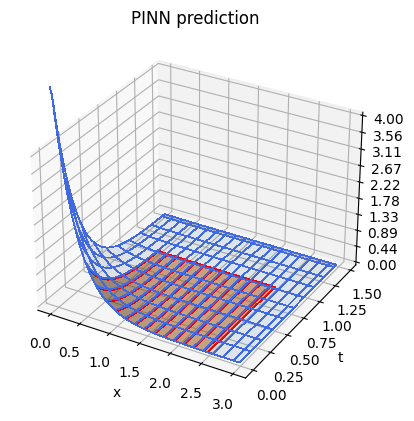

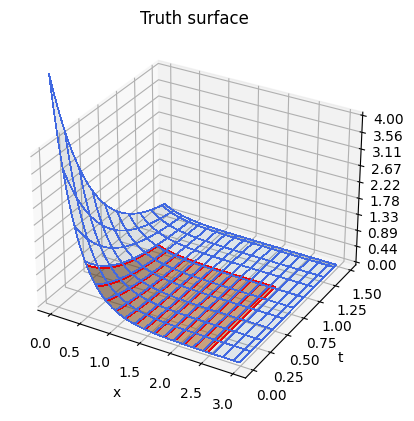

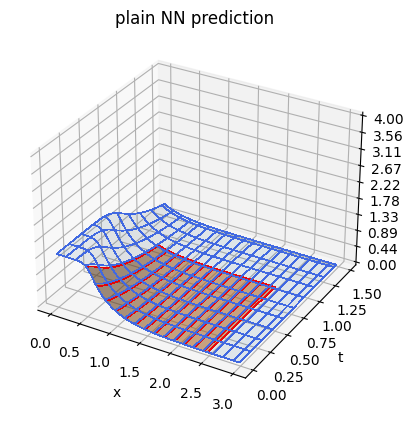

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plot_surface(ms_x, ms_t, ms_u, ms_x_ext, ms_t_ext, ms_u_ext, title):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    surf_ext = ax.plot_surface(
        ms_x_ext, ms_t_ext, ms_u_ext, edgecolor='royalblue', antialiased=False, label="w/ extrapolation",
        lw=0.5, rstride=8, cstride=8, alpha=0.1
    )
    surf = ax.plot_surface(
        ms_x, ms_t, ms_u, edgecolor='red', linewidth=0, antialiased=False, label="wo/ extrapolation",
        lw=0.5, rstride=8, cstride=8, alpha=0.5
    )
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    #plt.legend()
    plt.title(title)
    ax.set_xlabel("x"); ax.set_ylabel("t")
    ax.set_zlim(0.0,4.0)
    plt.show()

# x and t with and without extrapolation
x, t = np.arange(0.5, 2.5, 0.02), np.arange(0.0, 1.0, 0.02)
x_ext, t_ext = np.arange(0.0, 3.0, 0.02), np.arange(0.0, 1.5, 0.02)
ms_x, ms_t = np.meshgrid(x, t)
ms_x_ext, ms_t_ext = np.meshgrid(x_ext, t_ext)

# PINN prediction. Just because meshgrid is used, we need to do the following adjustment
x, t = np.ravel(ms_x).reshape(-1,1), np.ravel(ms_t).reshape(-1,1)
x_ext, t_ext = np.ravel(ms_x_ext).reshape(-1,1), np.ravel(ms_t_ext).reshape(-1,1)
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_x_ext = Variable(torch.from_numpy(x_ext).float(), requires_grad=True).to(device)
pt_t_ext = Variable(torch.from_numpy(t_ext).float(), requires_grad=True).to(device)

pt_u = net(pt_x,pt_t)
u = pt_u.data.cpu().numpy()
ms_u_pred = u.reshape(ms_x.shape)
pt_u_ext = net(pt_x_ext, pt_t_ext)
u_ext = pt_u_ext.data.cpu().numpy()
ms_u_pred_ext = u_ext.reshape(ms_x_ext.shape)
plot_surface(ms_x, ms_t, ms_u_pred, ms_x_ext, ms_t_ext, ms_u_pred_ext, title="PINN prediction")

# Plot truth surface
ms_u_truth = 6*np.exp(-3*ms_x-2*ms_t)
ms_u_truth_ext = 6*np.exp(-3*ms_x_ext-2*ms_t_ext)
plot_surface(ms_x, ms_t, ms_u_truth, ms_x_ext, ms_t_ext, ms_u_truth_ext, title="Truth surface")

# Plot surface from a plain neural network
pt_u_plain = net_plain(pt_x,pt_t)
u_plain = pt_u_plain.data.cpu().numpy()
ms_u_plain_pred = u_plain.reshape(ms_x.shape)
pt_u_plain_ext = net_plain(pt_x_ext, pt_t_ext)
u_plain_ext = pt_u_plain_ext.data.cpu().numpy()
ms_u_plain_pred_ext = u_plain_ext.reshape(ms_x_ext.shape)
plot_surface(ms_x, ms_t, ms_u_plain_pred, ms_x_ext, ms_t_ext, ms_u_plain_pred_ext, title="plain NN prediction")

# Other examples

The concepts of diffusion and techniques such as Physics-Informed Neural Networks (PINNs) can be adapted to model and predict phenomena like population growth or disease dynamics in epidemiological models such as the SIR (Susceptible, Infected, Recovered) model. Although the classical diffusion equation is more commonly used for physical processes, the underlying principles can be applied to model the spread of diseases or population growth with certain adjustments.

****Application Example in the SIR Model****

The SIR model is a basic epidemiological model that describes how a disease spreads in a population. This model divides the population into three compartments:



 
 
1.  $S(t)$: Number of susceptible individuals.
2.  $I(t)$: Number of infected individuals.
3.  $R(t)$: Number of recovered (or immunized) individuals.
 

The differential equations describing the SIR model are:

$$
\frac{dS(t)}{dt} = -\beta S(t) I(t)
$$

$$
\frac{dI(t)}{dt} = \beta S(t) I(t) - \gamma I(t)
$$

$$
\frac{dR(t)}{dt} = \gamma I(t)
$$

Where:


1. $\beta$ is the contact rate between susceptible and infected individuals.
2. $\gamma$ is the recovery rate.


****Using PINNs to Model the SIR****

Below is a Python code snippet that uses a PINN to approximate the solution of the SIR model. In this case, the PINN will be trained to learn the solutions of $S(t)$, $I(t)$, and $R(t)$ as a function of time.


# SIR can be used to predict COVID or MPOX

2024-08-22 18:34:36.650947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 18:34:36.651138: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 18:34:36.814995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 0, Loss: 0.9825252294540405
Epoch 1000, Loss: 4.201462161290692e-06
Epoch 2000, Loss: 2.7413625502958894e-06
Epoch 3000, Loss: 2.3179075014923e-06
Epoch 4000, Loss: 3.364375970704714e-06
Epoch 5000, Loss: 2.8597407890629256e-06
Epoch 6000, Loss: 8.415374395553954e-06
Epoch 7000, Loss: 8.19154956843704e-06
Epoch 8000, Loss: 1.381978472636547e-05
Epoch 9000, Loss: 7.135067221497593e-07
Epoch 0, Loss: 0.9824737310409546
Epoch 1000, Loss: 2.6879306460614316e-06
Epoch 2000, Loss: 1.4240092696127249e-06
Epoch 3000, Loss: 1.207317950502329e-06
Epoch 4000, Loss: 1.8240873487229692e-06
Epoch 5000, Loss: 7.87843055150006e-06
Epoch 6000, Loss: 5.740157575928606e-06
Epoch 7000, Loss: 4.2747993575176224e-05
Epoch 8000, Loss: 7.707751592533896e-07
Epoch 9000, Loss: 2.5070929041248746e-05


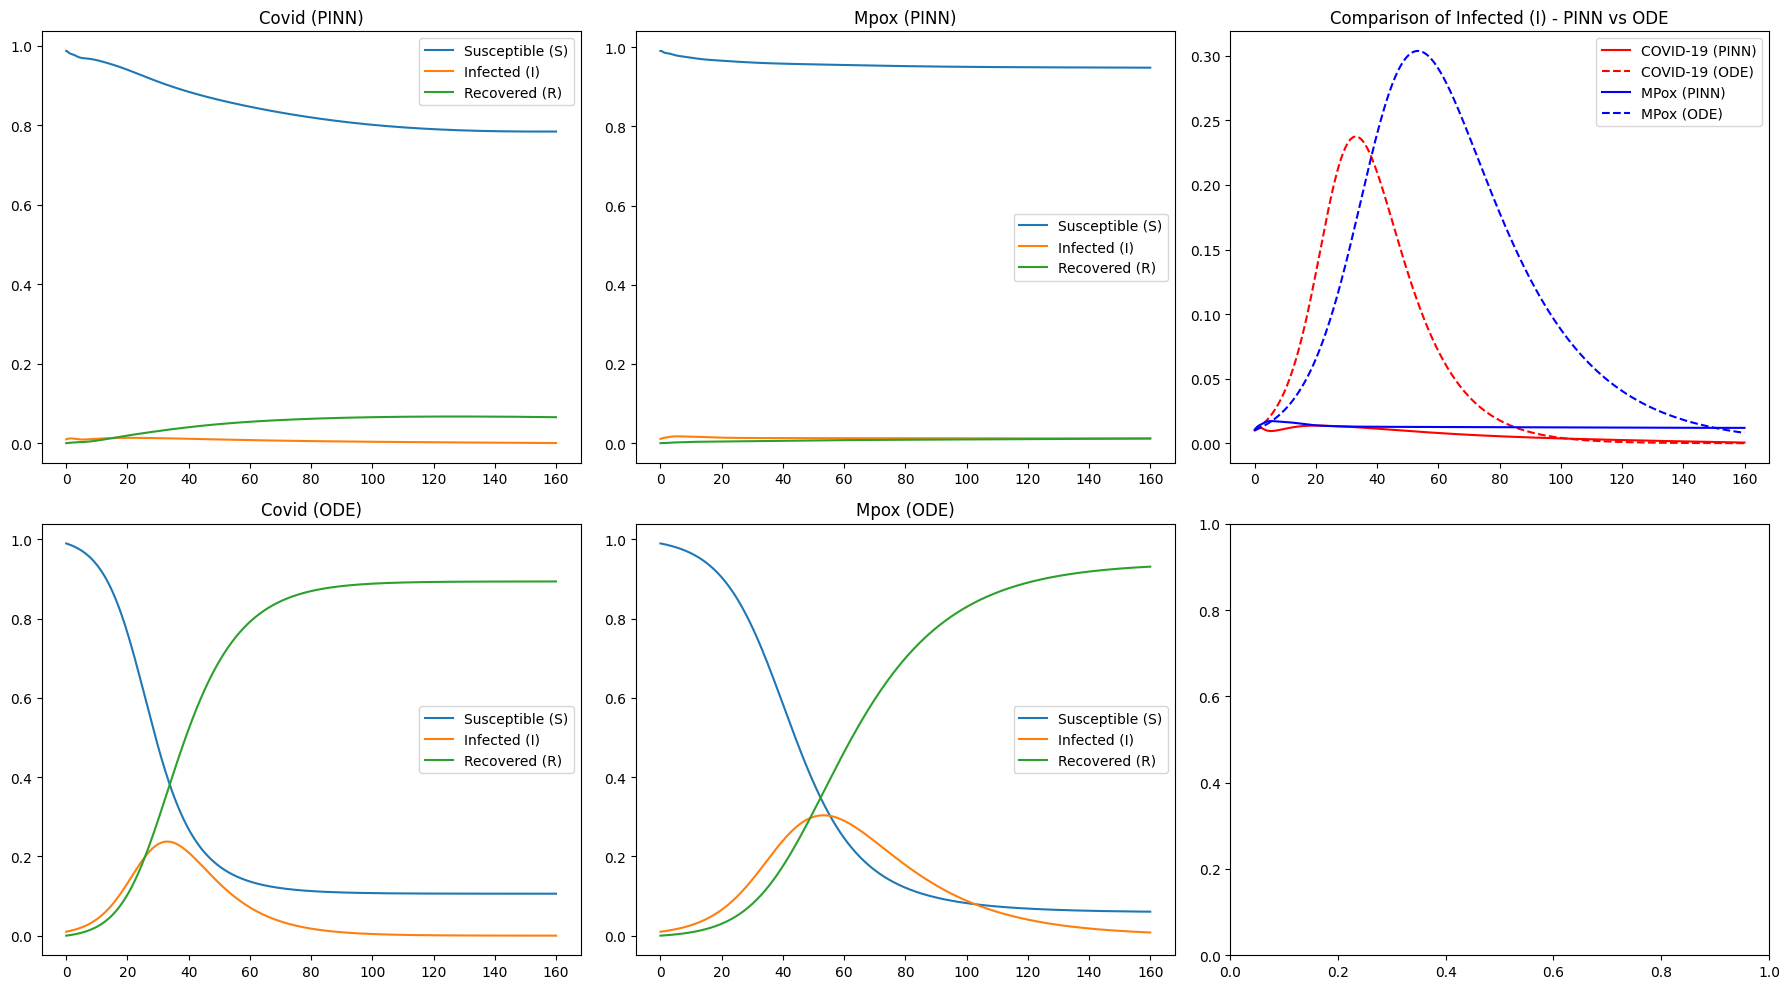

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parámetros del modelo SIR para COVID-19 y MPox
params = {
    'covid': {'beta': 0.25, 'gamma': 0.1},
    'mpox': {'beta': 0.15, 'gamma': 0.05}
}

# Condiciones iniciales
S0 = 0.99
I0 = 0.01
R0 = 0.0

# Tiempo
t_np = np.linspace(0, 160, 500)[:, None]
t = tf.convert_to_tensor(t_np, dtype=tf.float32)

# Definición del PINN
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [
            tf.keras.layers.Dense(64, activation='tanh') for _ in range(3)
        ]
        self.output_layer = tf.keras.layers.Dense(3)  # S, I, R

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

def pinn_loss(model, t, S0, I0, R0, beta, gamma):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        SIR = model(t)
        S = SIR[:, 0:1]
        I = SIR[:, 1:2]
        R = SIR[:, 2:3]

        # Derivadas
        dS_dt = tape.gradient(S, t)
        dI_dt = tape.gradient(I, t)
        dR_dt = tape.gradient(R, t)

    # Asegurarse de que las derivadas no sean None
    if dS_dt is None or dI_dt is None or dR_dt is None:
        raise ValueError("El modelo produjo una salida None. Asegúrese de que la red esté correctamente configurada.")

    # Ecuaciones diferenciales del modelo SIR
    f1 = dS_dt + beta * S * I
    f2 = dI_dt - beta * S * I + gamma * I
    f3 = dR_dt - gamma * I

    # Pérdida inicial y de PDE
    ic_loss = tf.reduce_mean((S[0] - S0) ** 2) + tf.reduce_mean((I[0] - I0) ** 2) + tf.reduce_mean((R[0] - R0) ** 2)
    pde_loss = tf.reduce_mean(f1 ** 2) + tf.reduce_mean(f2 ** 2) + tf.reduce_mean(f3 ** 2)

    return ic_loss + pde_loss

def train_pinn(model, t, beta, gamma, epochs=10000, lr=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = pinn_loss(model, t, S0, I0, R0, beta, gamma)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Método clásico usando scipy.integrate.odeint
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def solve_ode(beta, gamma):
    y0 = [S0, I0, R0]
    return odeint(sir_model, y0, t_np.flatten(), args=(beta, gamma))

# Entrenar y predecir para COVID-19 y MPox
models = {}
results_pinn = {}
results_ode = {}

for disease, param in params.items():
    # Entrenar PINN
    model = PINN()
    train_pinn(model, t, param['beta'], param['gamma'])
    models[disease] = model

    # Predecir usando PINN
    SIR_pred = model(t)
    results_pinn[disease] = {
        'S': SIR_pred[:, 0].numpy(),
        'I': SIR_pred[:, 1].numpy(),
        'R': SIR_pred[:, 2].numpy()
    }

    # Resolver usando ODE
    ode_result = solve_ode(param['beta'], param['gamma'])
    results_ode[disease] = {
        'S': ode_result[:, 0],
        'I': ode_result[:, 1],
        'R': ode_result[:, 2]
    }

# Graficar los resultados

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, (disease, label) in enumerate(params.items()):
    # PINN
    axs[0, i].plot(t_np, results_pinn[disease]['S'], label='Susceptible (S)')
    axs[0, i].plot(t_np, results_pinn[disease]['I'], label='Infected (I)')
    axs[0, i].plot(t_np, results_pinn[disease]['R'], label='Recovered (R)')
    axs[0, i].set_title(f"{disease.capitalize()} (PINN)")
    axs[0, i].legend()

    # ODE
    axs[1, i].plot(t_np, results_ode[disease]['S'], label='Susceptible (S)')
    axs[1, i].plot(t_np, results_ode[disease]['I'], label='Infected (I)')
    axs[1, i].plot(t_np, results_ode[disease]['R'], label='Recovered (R)')
    axs[1, i].set_title(f"{disease.capitalize()} (ODE)")
    axs[1, i].legend()

# Comparación directa de PINN vs ODE
axs[0, 2].plot(t_np, results_pinn['covid']['I'], label='COVID-19 (PINN)', color='r')
axs[0, 2].plot(t_np, results_ode['covid']['I'], label='COVID-19 (ODE)', color='r', linestyle='--')
axs[0, 2].plot(t_np, results_pinn['mpox']['I'], label='MPox (PINN)', color='b')
axs[0, 2].plot(t_np, results_ode['mpox']['I'], label='MPox (ODE)', color='b', linestyle='--')
axs[0, 2].set_title("Comparison of Infected (I) - PINN vs ODE")
axs[0, 2].legend()

plt.tight_layout()
plt.show()


# Other example

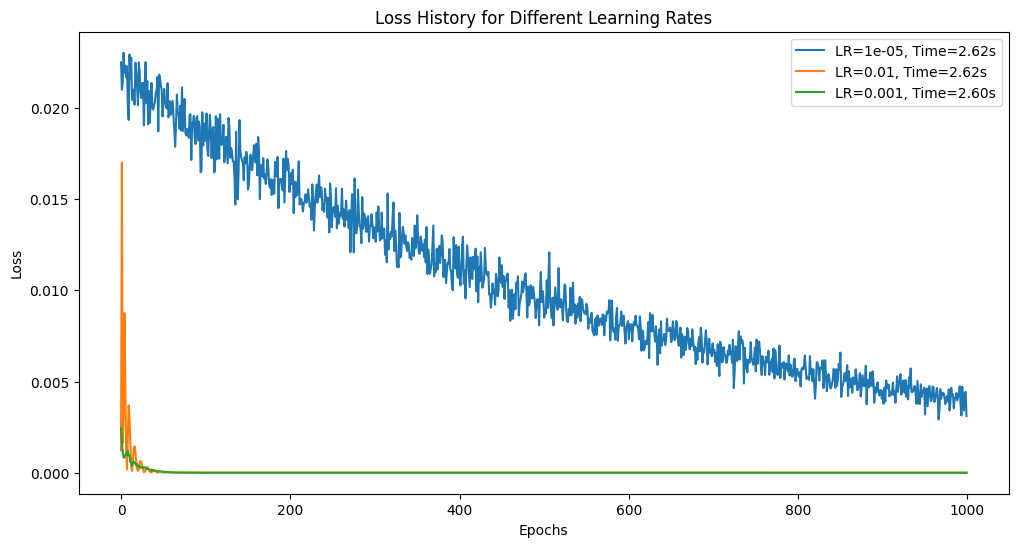

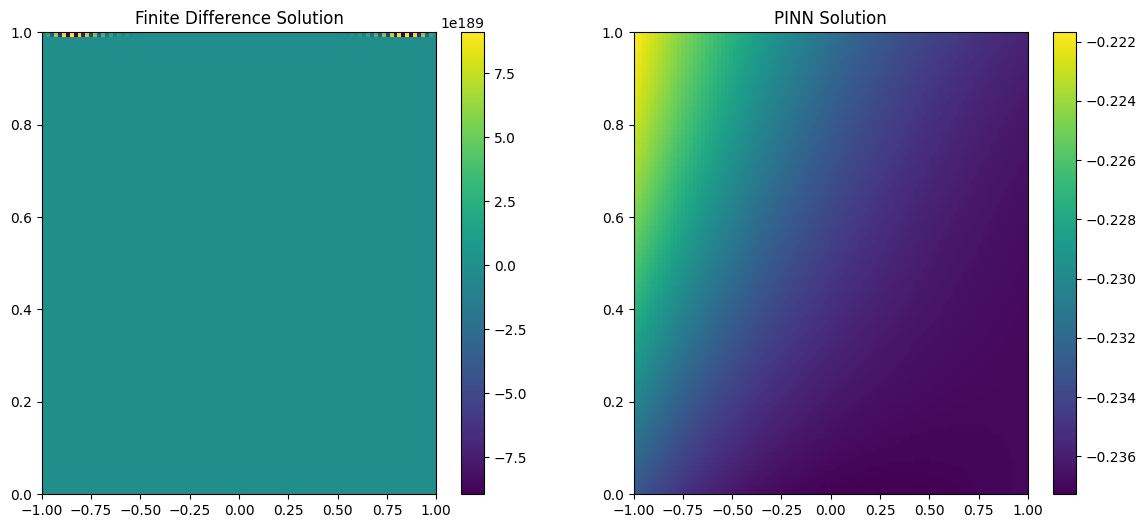

Tiempos de cómputo (en segundos):
{'PINN (Optimum LR)': 2.599720001220703, 'Finite Differences': 0.002418041229248047}


In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

# Definir la ecuación de difusión
D = 1.0  # coeficiente de difusión

# Crear la red neuronal para el PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def forward(self, x, t):
        x = torch.cat((x, t), dim=1)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Definir la función de pérdida
def pde_loss(model, x, t):
    x.requires_grad = True
    t.requires_grad = True
    
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    loss = torch.mean((u_t - D * u_xx) ** 2)
    return loss

# Función para entrenar el PINN
def train_pinn(epochs, lr):
    model = PINN()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    start_time = time.time()
    for epoch in range(epochs):
        x = torch.rand(100, 1) * 2 - 1  # x in [-1, 1]
        t = torch.rand(100, 1)  # t in [0, 1]
        loss = pde_loss(model, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    elapsed_time = time.time() - start_time
    return model, loss_history, elapsed_time

# Configuraciones de entrenamiento
epochs = 1000
learning_rates = [1e-5, 1e-2, 1e-3]  # bajo, alto, óptimo

# Entrenamiento con diferentes tasas de aprendizaje
results = {}
for lr in learning_rates:
    model, loss_history, elapsed_time = train_pinn(epochs, lr)
    results[lr] = {
        "model": model,
        "loss_history": loss_history,
        "time": elapsed_time
    }

# Graficar la historia de la pérdida para cada tasa de aprendizaje
plt.figure(figsize=(12, 6))
for lr in learning_rates:
    plt.plot(results[lr]["loss_history"], label=f'LR={lr}, Time={results[lr]["time"]:.2f}s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History for Different Learning Rates')
plt.show()

# Resolver el mismo problema usando diferencias finitas
def finite_difference_solver(D, Nx=100, Nt=100, T=1.0, L=2.0):
    dx = L / (Nx - 1)
    dt = T / Nt
    alpha = D * dt / dx**2
    
    x = np.linspace(-L/2, L/2, Nx)
    u = np.exp(-x**2)  # initial condition: Gaussian profile
    u_fd = np.zeros((Nt, Nx))
    u_fd[0, :] = u

    for n in range(0, Nt-1):
        u[1:-1] = u[1:-1] + alpha * (u[2:] - 2*u[1:-1] + u[:-2])
        u_fd[n+1, :] = u

    return x, u_fd

# Resolver la ecuación de difusión usando diferencias finitas
Nx, Nt = 100, 100
x_fd, u_fd = finite_difference_solver(D, Nx=Nx, Nt=Nt)

# Usar el PINN con LR óptimo para hacer predicciones
model_opt = results[1e-3]["model"]
x = torch.tensor(x_fd, dtype=torch.float32).reshape(-1, 1)
t = torch.linspace(0, 1, Nt).reshape(-1, 1)

u_pinn = np.zeros_like(u_fd)
for i in range(Nt):
    t_i = t[i].expand_as(x)
    u_pinn[i, :] = model_opt(x, t_i).detach().numpy().flatten()

# Graficar los resultados
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(u_fd, extent=[x_fd.min(), x_fd.max(), 0, 1], aspect='auto', origin='lower')
plt.colorbar()
plt.title('Finite Difference Solution')

plt.subplot(1, 2, 2)
plt.imshow(u_pinn, extent=[x_fd.min(), x_fd.max(), 0, 1], aspect='auto', origin='lower')
plt.colorbar()
plt.title('PINN Solution')

plt.show()

# Evaluación del tiempo de cómputo para diferencias finitas
start_time = time.time()
finite_difference_solver(D, Nx=Nx, Nt=Nt)
elapsed_time_fd = time.time() - start_time

# Comparación de tiempos
results_time = {
    "PINN (Optimum LR)": results[1e-3]["time"],
    "Finite Differences": elapsed_time_fd
}

print("Tiempos de cómputo (en segundos):")
print(results_time)


More complex

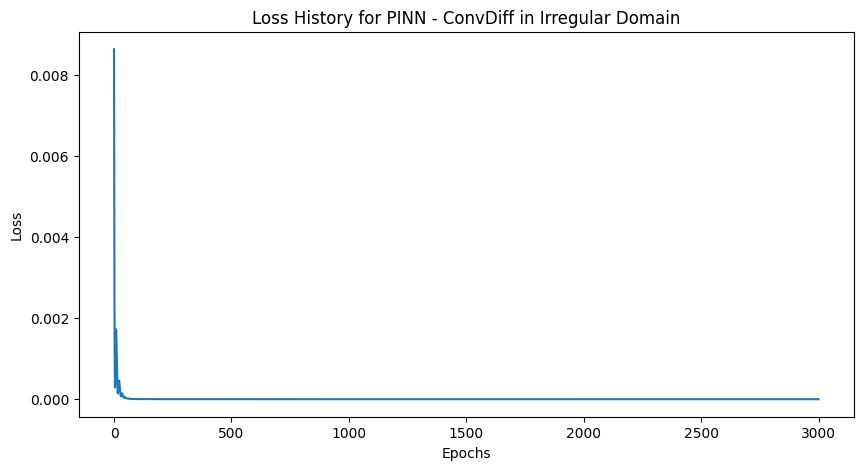

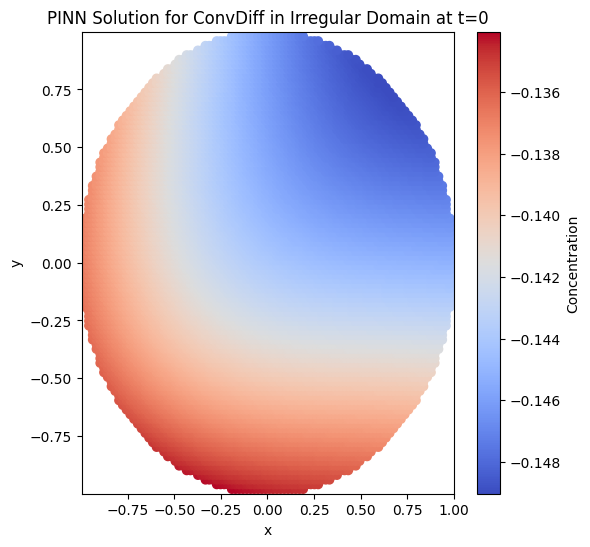

In [11]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

# Definir la ecuación de difusión-convección en un dominio irregular
D = 0.1  # coeficiente de difusión
vx, vy = 1.0, 0.5  # velocidades de convección

# Crear la red neuronal para el PINN
class PINN_ConvDiff(nn.Module):
    def __init__(self):
        super(PINN_ConvDiff, self).__init__()
        self.fc1 = nn.Linear(3, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 1)
    
    def forward(self, x, y, t):
        input = torch.cat((x, y, t), dim=1)
        h = torch.tanh(self.fc1(input))
        h = torch.tanh(self.fc2(h))
        h = torch.tanh(self.fc3(h))
        output = self.fc4(h)
        return output

# Definir la función de pérdida
def pde_loss(model, x, y, t):
    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True
    
    u = model(x, y, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True)[0]
    
    loss = torch.mean((u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy)) ** 2)
    return loss

# Crear el dominio irregular (un círculo con una cavidad)
def create_irregular_domain():
    theta = np.linspace(0, 2 * np.pi, 100)
    outer_circle = np.vstack([np.cos(theta), np.sin(theta)]).T
    inner_circle = 0.3 * np.vstack([np.cos(theta), np.sin(theta)]).T
    points = np.vstack([outer_circle, inner_circle])
    
    tri = Delaunay(points)
    return points, tri

# Generar puntos de entrenamiento en el dominio irregular
def generate_training_data(points, tri, num_points=1000):
    indices = np.random.choice(tri.simplices.shape[0], num_points)
    selected_simplices = tri.simplices[indices]
    barycentric_coords = np.random.rand(num_points, 3)
    barycentric_coords /= np.sum(barycentric_coords, axis=1)[:, None]
    
    selected_points = np.einsum('ijk,ij->ik', points[selected_simplices], barycentric_coords)
    x_train = selected_points[:, 0]
    y_train = selected_points[:, 1]
    t_train = np.random.rand(num_points)
    
    return torch.tensor(x_train, dtype=torch.float32).reshape(-1, 1), torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1), torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)

# Entrenamiento del PINN
def train_pinn_conv_diff(epochs, lr):
    model = PINN_ConvDiff()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []
    
    points, tri = create_irregular_domain()
    x_train, y_train, t_train = generate_training_data(points, tri)
    
    for epoch in range(epochs):
        loss = pde_loss(model, x_train, y_train, t_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        
    return model, loss_history, points, tri

# Configuración de entrenamiento
epochs = 3000
lr = 1e-3  # Tasa de aprendizaje óptima para este ejemplo

# Entrenar el PINN
model, loss_history, points, tri = train_pinn_conv_diff(epochs, lr)

# Graficar la historia de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History for PINN - ConvDiff in Irregular Domain')
plt.show()

# Evaluación del PINN en un grid dentro del dominio irregular
x_eval = np.linspace(-1, 1, 100)
y_eval = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x_eval, y_eval)
x_flat = X.flatten()
y_flat = Y.flatten()

# Filtrar puntos dentro del dominio irregular
inside = np.sqrt(x_flat**2 + y_flat**2) <= 1.0
x_eval_inside = torch.tensor(x_flat[inside], dtype=torch.float32).reshape(-1, 1)
y_eval_inside = torch.tensor(y_flat[inside], dtype=torch.float32).reshape(-1, 1)
t_eval = torch.zeros_like(x_eval_inside)  # Evaluación en t = 0

# Predicciones con el PINN
u_pred = model(x_eval_inside, y_eval_inside, t_eval).detach().numpy()

# Graficar los resultados
plt.figure(figsize=(6, 6))
plt.tricontourf(points[:, 0], points[:, 1], tri.simplices, np.zeros(points.shape[0]), cmap='coolwarm', alpha=0.3)
plt.scatter(x_eval_inside.numpy(), y_eval_inside.numpy(), c=u_pred, cmap='coolwarm')
plt.colorbar(label='Concentration')
plt.title('PINN Solution for ConvDiff in Irregular Domain at t=0')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# And more... (Cancer inmunoediting)

### System of Partial Differential Equations (PDEs)

Consider the following dependent variables:

- $u(t, x) $: Density of tumor cells at time $t$  and position $x$.
- $ v(t, x) $: Density of immune cells at time $t$ and position $x$.
- $ w(t, x) $: Density of tumor cells that have escaped immune control at time $t$ and position $x$.

The PDEs that describe the system are:

#### Equation for Tumor Cells \( u(t, x) \):

\[
\frac{\partial u}{\partial t} = \alpha u - \beta u v + D_u \frac{\partial^2 u}{\partial x^2}
\]

Where:

- $\alpha$: Growth rate of tumor cells.
- $\beta$: Elimination rate of tumor cells by immune cells.
- $D_u$: Diffusion coefficient of tumor cells (models spatial dispersion).

#### Equation for Immune Cells \( v(t, x) \):

$$
\frac{\partial v}{\partial t} = \gamma v - \delta v u + D_v \frac{\partial^2 v}{\partial x^2}
$$

Where:

- $\gamma$: Activation/proliferation rate of immune cells.
- $\delta$: Suppression rate of immune cells by tumor cells.
- $D_v$: Diffusion coefficient of immune cells.

#### Equation for Escaped Tumor Cells \( w(t, x) \):

$$
\frac{\partial w}{\partial t} = \beta u v - \epsilon w + D_w \frac{\partial^2 w}{\partial x^2}
$$

Where:

- $\epsilon$ : Natural death rate of escaped tumor cells.
- $ D_w$ : Diffusion coefficient of escaped tumor cells.

### Description of the Equations

- **First equation**: Models the growth of tumor cells, their elimination by immune cells, and their dispersion in the tissue.
- **Second equation**: Models the immune system's response, including the activation of immune cells in response to the tumor and their suppression due to the tumor.
- **Third equation**: Models the appearance and dispersion of tumor cells that have developed mechanisms to evade the immune system.

This system of PDEs captures the essential dynamics of the cancer immunoediting process, including the three key phases: elimination, equilibrium, and escape. The constants \( \alpha, \beta, \gamma, \delta, \epsilon \) and diffusion coefficients \( D_u, D_v, D_w \) can be adjusted according to specific biological contexts or available experimental data.

These equations can be solved using numerical techniques and tools like PINNs to study the system's behavior under different conditions and parameters.
